In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
from phasor import QWR029, QWR041, QWR053, QWR085
from phasor.torch_helper import run_torch_optimizer, run_torch_optimizer_multi_args
from phasor import _beam_frequency as _ref_frequency
_ref_wavelength = 299792458 / _ref_frequency
import numpy as np
import torch
import torch.profiler
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import json
from IPython.display import display
from typing import Optional, List, Any
from dataclasses import dataclass
from collections import namedtuple
from scipy.optimize import minimize

In [3]:
def read_tunfile(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    for line in lines:
        if line.startswith("# Beam A:"):
            A = float(line.split(":")[1].strip())
        elif line.startswith("# Beam Q:"):
            Q = float(line.split(":")[1].strip())
        elif line.startswith("# Beam Q stripped:"):
            Qstrip = float(line.split(":")[1].strip())
        elif line.startswith("# Beam init energy (eV/u):"):
            Wu0 = float(line.split(":")[1].strip())
        elif line.startswith("# Beam init phase (deg):"):
            tau0 = float(line.split(":")[1].strip())/180*np.pi
        elif line.startswith("# Timestamp:"):
            Timestamp = line.split(":")[1].strip()
        elif line.startswith("N\t"):
            # Read the dataframe from this line onwards using pandas read_csv
            dataframe = pd.read_csv(filename, skiprows=lines.index(line), delimiter='\t', index_col='N')
            break
    return A, Q, Qstrip, tau0, Wu0, Timestamp, dataframe

In [4]:
def Wu2beta(w_u):  
    gamma = 1.+w_u/931.5e6
    return torch.sqrt(1.0 - 1.0 / gamma ** 2)

class drift_map:
    def __init__(self, name, 
                 zc, 
                 # distance,
                 phase,
                 offset,
                 ref_frequency=_ref_frequency):
        self.name = name
        # self.distance = distance
        self.zc = zc
        self.ref_wavelength = 299792458 / ref_frequency
        if isinstance(offset, torch.Tensor):
            self.offset = offset.to(dtype=torch.float64)
        else:
            self.offset = torch.tensor(offset,dtype=torch.float64)
        if isinstance(phase, torch.Tensor):
            self.phase = phase.to(dtype=torch.float64)
        else:
            self.phase = torch.tensor(phase,dtype=torch.float64)
    
    def __call__(self, z, tau, Wu):
        tau = tau.double()
        Wu  = Wu.double()
        distance = self.zc-z
        return z+distance, tau + 2.0 * torch.pi * distance / (Wu2beta(Wu) * self.ref_wavelength),   Wu
        # return tau + 2.0 * torch.pi * self.distance / (Wu2beta(Wu) * self.ref_wavelength),   Wu

class cav_map:
    def __init__(self, name, 
                 zc,
                 # distance,
                 model, QA, scale, 
                 amplitude, phase,
                 offset,
                 ref_frequency=_ref_frequency,
                 is_on = True):        
        self.name = name
        # self.distance = distance
        self.zc = zc
        self.length = model.cav_length
        self.frequency = model.cav_frequency
        self.ref_wavelength = 299792458 / ref_frequency
        self.ref_frequency  = ref_frequency
        self.model = model
        self.is_on = is_on
        if isinstance(QA,torch.Tensor):
            self.QA = QA.to(dtype=torch.float32)
        else:
            self.QA = torch.tensor(QA,dtype=torch.float32)
        if isinstance(amplitude, torch.Tensor):
            self.amplitude = amplitude.to(dtype=torch.float64)
        else:
            self.amplitude = torch.tensor(amplitude,dtype=torch.float64)
        if isinstance(scale, torch.Tensor):
            self.scale = scale.to(dtype=torch.float64)
        else:
            self.scale = torch.tensor(scale,dtype=torch.float64)
        if isinstance(offset, torch.Tensor):
            self.offset = offset.to(dtype=torch.float64)
        else:
            self.offset = torch.tensor(offset,dtype=torch.float64)
        if isinstance(phase, torch.Tensor):
            self.phase = phase.to(dtype=torch.float64)
        else:
            self.phase = torch.tensor(phase,dtype=torch.float64)


    def __call__(self, z, tau, Wu, amplitude=None, phase=None):
        if not self.is_on:
            distance = self.zc - z + 0.5 * self.length
            return z + distance, tau + 2.0 * torch.pi * distance / (Wu2beta(Wu) * self.ref_wavelength), Wu
        if phase is None:
            phase = self.phase
        if amplitude is None:
            amplitude = self.amplitude
    
        tau = tau.double()
        Wu = Wu.double()
        distance = self.zc - z - 0.5 * self.length
        tau = tau + 2.0 * np.pi * distance / (Wu2beta(Wu) * self.ref_wavelength)
        phase = self.frequency / self.ref_frequency * tau + phase + self.offset
        dTau, dWu_out = self.model(phase, Wu, amplitude * self.scale, self.QA)
        Wu = Wu + dWu_out.double()
        tau = tau + dTau.double() + 2.0 * np.pi * self.length / (Wu2beta(Wu) * self.ref_wavelength)
        return z + distance + self.length, tau, Wu
    
        
    # def __call__(self, z, 
    #              tau, Wu, amplitude=None, phase = None):
    #     if not self.is_on:
    #         distance = self.zc -z +0.5*self.length
    #         return z+distance, tau + 2.0*torch.pi*distance / (Wu2beta(Wu) * self.ref_wavelength),   Wu
    #     if phase is None:
    #         phase = self.phase
    #     if amplitude is None:
    #         amplitude = self.amplitude

    #     tau = tau.double()
    #     Wu  = Wu.double()
    #     distance = self.zc -z -0.5*self.length
    #     # distance = self.distance -0.5*self.length
    #     tau = tau + 2.0 * np.pi * distance / (Wu2beta(Wu) * self.ref_wavelength)
    #     phase = self.frequency / self.ref_frequency * tau + phase + self.offset
    #     dTau, dWu_out = self.model(phase, Wu, amplitude*self.scale, self.QA)
    #     Wu = Wu   + dWu_out.double()
    #     tau = tau + dTau.double() +  2.0*np.pi*self.length/(Wu2beta(Wu) * self.ref_wavelength)
    #     return z + distance + self.length, tau, Wu
    #     # return tau, Wu

def wrap(phases, limit=180.0):
    range_ = limit * 2.0
    return ((phases + limit) % range_) - limit

def cyclic_distance(x, y, period, eps=1e-2):
    x = torch.as_tensor(x, dtype=torch.float64)
    y = torch.as_tensor(y, dtype=torch.float64)
    delta = (x - y + period / 2) % period - period / 2
    eps = eps*period
    return torch.sqrt(delta**2 + eps**2) - eps

def cyclic_differebce(x, y, period):
    x = torch.as_tensor(x, dtype=torch.float64)
    y = torch.as_tensor(y, dtype=torch.float64)
    delta = (x - y + period / 2) % period - period / 2
    return delta

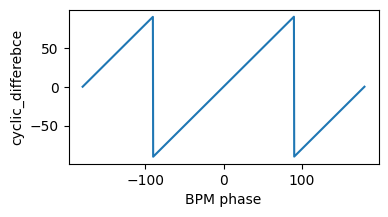

In [5]:
x = torch.linspace(-180,180,1024)
y = torch.zeros(1024)*90
period = 180
dist = cyclic_differebce(x,y,180)
plt.figure(figsize=(4,2))
plt.plot(x,dist)
plt.xlabel('BPM phase');
plt.ylabel('cyclic_differebce');

In [6]:
@dataclass
class lattice:
    latfile: Optional[str] = None
    vprfile: Optional[str] = None
    tunfile: Optional[str] = None
    A: Optional[float] = None
    Q: Optional[float] = None
    Qstrip: Optional[Any] = None
    Wu_init: Optional[Any] = None  # MeV
    tau_init: Optional[Any] = None  # radian
    l_amplitude: Optional[Any] = None
    l_cav_synch_phase: Optional[Any] = None  # radian
    l_phase: Optional[Any] = None  # radian
    from_element: Optional[str] = None
    to_element: Optional[str] = None
    to_cav: Optional[str] = None
    
    def __post_init__(self):
        assert self.latfile or self.tunfile
        if self.latfile is not None:
            lattice_df = pd.read_csv(self.latfile, delimiter='\t', index_col='N')
            if self.vprfile is not None:
                vpr_df = pd.read_csv(self.vprfile, delimiter='\t', index_col='N')
                if self.Q and self.A:
                    vpr_df['field(MV/m)'] = vpr_df['E*q/A(MV/m)']*self.A/self.Q
                assert (vpr_df["Name"].values == lattice_df["Name"].values).all()
                lattice_df = pd.concat((lattice_df,vpr_df),axis=1)
        if self.tunfile:
            A, Q, Qstrip, tau_init, Wu_init, _, lattice_df = read_tunfile(self.tunfile)
            self.A = self.A or A
            self.Q = self.Q or Q
            self.Qstrip = self.Qstrip or Qstrip
            self.Wu_init = self.Wu_init or Wu_init
            self.tau_init = self.tau_init or tau_init
            
        i_from_element = 0
        i_to_element = len(lattice_df)
        if self.from_element:
            match = lattice_df.index[lattice_df['Name'] == self.from_element]
            if len(match) == 0:
                raise ValueError(f"from_element '{self.from_element}' not found.")
            i_from_element = match[0]
        if self.to_element:
            i_to_element = lattice_df.index[lattice_df['Name'] == self.to_element][0] + 1
        lattice_df = lattice_df.iloc[i_from_element:i_to_element].reset_index(drop=True)
        assert 'BPM' in lattice_df['Name'][0]
        lattice_df['z(mm)'] -= lattice_df['z(mm)'].loc[0]
        # lattice_df['offset(deg)'] -= lattice_df['offset(deg)'].loc[0]
        self.lattice_df = lattice_df
        
        self.i_cav = [i for i, name in enumerate(self.lattice_df['Name']) if 'RFC' in name]
        self.i_bpm = [i for i, name in enumerate(self.lattice_df['Name']) if 'BPM' in name]
        
        if not self.i_cav:
            raise ValueError("No RFC cavities found in lattice!")
        
        if 'field(MV/m)' not in self.lattice_df.columns:
            self.lattice_df['field(MV/m)'] = 0.0
        if self.l_amplitude is not None:
            self.lattice_df.loc[self.i_cav, 'field(MV/m)'] = self.l_amplitude

        if 'phase(deg)' not in self.lattice_df.columns:
            self.lattice_df['phase(deg)'] = 0.0
        if self.l_phase is not None:
            self.lattice_df.loc[self.i_cav, 'phase(deg)'] = np.array(self.l_phase)/np.pi*180
        
        if 'Sync.phase(deg)' not in self.lattice_df.columns:
            self.lattice_df['Sync.phase(deg)'] = 0.0
        if self.l_cav_synch_phase is not None:
            self.lattice_df.loc[self.i_cav, 'Sync.phase(deg)'] = np.array(self.l_cav_synch_phase)/np.pi*180

        self.lattice_df['is_on'] = '' 
        
        del self.l_amplitude
        del self.l_cav_synch_phase
        del self.l_phase
        
        self.l_map = []
        self.l_cav_map = []
        is_on = True
        for zc, name, scale, amplitude, phase, offset in zip( # self.lattice_df.index,
                                                                self.lattice_df['z(mm)']*1e-3,
                                                                self.lattice_df['Name'],
                                                                self.lattice_df['scale'],
                                                                self.lattice_df['field(MV/m)'],
                                                                self.lattice_df['phase(deg)'],
                                                                self.lattice_df['offset(deg)'],
                                                                ):
            offset = offset/180*np.pi
            phase  = phase/180*np.pi
            if 'RFC' in name:
                if 'LS1_CA' in name:
                    model = QWR041
                elif 'LS1_CB' in name or 'FS1_CH' in name:
                    model = QWR085
                elif 'LS2_CC' in name:
                    model = QWR029
                elif 'LS2_CD' in name or 'FS2_CG' in name or 'LS3_CD' in name:
                    model = QWR053
                elif 'MEBT:RFC' in name or 'FS1_MGB' in name or 'STRIP' in name:
                    raise NotImplementedError(f"Cavity model for {name} not implemented")
                cavity = cav_map(name, zc, model, self.Q/self.A, scale, amplitude, phase, offset, is_on=is_on)
                loc = self.lattice_df.index[self.lattice_df['Name'] == name][0]
                self.lattice_df.loc[loc,'is_on'] = is_on
                self.l_map.append(cavity)
                self.l_cav_map.append(cavity)
                if self.to_cav is not None:
                    if name == self.to_cav:
                        is_on = False
            else:
                self.l_map.append(drift_map(name, zc, phase, offset))

    def update_lattice_from_map(self):
        for M in self.l_map:
            loc = self.lattice_df.index[self.lattice_df['Name'] == M.name][0]
            if isinstance(M, cav_map):
                self.lattice_df.loc[loc,'phase(deg)'] = wrap(M.phase/np.pi*180,limit=180).item()
                self.lattice_df.loc[loc,'offset(deg)'] = wrap(M.offset/np.pi*180,limit=180).item()
                # self.lattice_df.loc[loc,'Sync.phase(deg)'] = wrap((M.phase-M.offset)/np.pi*180,limit=180).item()
                self.lattice_df.loc[loc,'field(MV/m)'] = M.amplitude.item()
                self.lattice_df.loc[loc,'scale'] = M.scale.item()
                self.lattice_df.loc[loc,'is_on'] = M.is_on
            else:
                self.lattice_df.loc[loc,'phase(deg)'] = wrap(M.phase/np.pi*180,limit=90).item()
                self.lattice_df.loc[loc,'offset(deg)'] = wrap(M.offset/np.pi*180,limit=90).item()

    def update_map_from_lattice(self):
        for M in self.l_map:
            loc = self.lattice_df.index[self.lattice_df['Name'] == M.name][0]
            M.phase = torch.tensor(self.lattice_df.loc[loc, 'phase(deg)'] / 180 * np.pi, dtype=torch.float64)
            M.offset = torch.tensor(self.lattice_df.loc[loc, 'offset(deg)'] / 180 * np.pi, dtype=torch.float64)
            if isinstance(M, cav_map):
                M.amplitude = torch.tensor(self.lattice_df.loc[loc, 'field(MV/m)'], dtype=torch.float64)
                M.scale = torch.tensor(self.lattice_df.loc[loc, 'scale'], dtype=torch.float64)
                M.is_on = self.lattice_df.loc[loc, 'is_on']

    def set_synch_phase(self, z=0.0, tau=None, Wu=None, l_cav_synch_phase=None):
        if tau is None:
            tau = self.tau_init
        if Wu is None:
            Wu = self.Wu_init
        tau = torch.tensor(tau, dtype=torch.float64)
        Wu  = torch.tensor(Wu, dtype=torch.float64)
        if l_cav_synch_phase is not None:
            assert len(l_cav_synch_phase) == len(self.i_cav)
            self.lattice_df.loc[self.i_cav, 'Sync.phase(deg)'] = np.array(l_cav_synch_phase)/np.pi*180
    
        for i,M in enumerate(self.l_map):
            # print("M.name,tau,Wu",M.name,tau,Wu)
            if isinstance(M, cav_map):
                if M.is_on:
                    synch_phase = self.lattice_df.loc[i,'Sync.phase(deg)']/180*np.pi
                    phase_opt = self.find_maxgain_phase(M, z, tau, Wu)
                    M.phase = wrap(phase_opt + synch_phase, limit=np.pi)
                    # self.lattice_df.loc[i,'phase(deg)'] = M.phase/np.pi*180
                z, tau, Wu = M(z, tau, Wu)
                tau = tau.detach()
                Wu = Wu.detach()
            else:
                z, tau, Wu = M(z, tau, Wu)
                M.phase = wrap(tau + M.offset, limit=np.pi)
                # self.lattice_df.loc[i,'phase(deg)'] = wrap(tau + M.offset, limit=np.pi)
        self.update_lattice_from_map()
    
    def find_maxgain_phase(self, cavity, z, tau, Wu, max_iter=100, lr=0.05, plot_history=False):
        def loss_func(phase):
            phase = phase.view(-1)
            _, tau_out, Wu_out = cavity(z, tau, Wu, phase=phase)
            return {'loss': -(Wu_out - Wu)*1e-6}
        result = run_torch_optimizer(loss_func, 
                                     torch.linspace(-torch.pi,torch.pi,8).view(-1,1), 
                                     max_iter=max_iter, 
                                     lr=lr, 
                                     plot_history=plot_history)
        return result.x[torch.argmin(result.losses['loss'])].item()

    def get_bpm_df(self):
        return self.lattice_df.loc[self.i_bpm]
        
    def get_cav_df(self):
        return self.lattice_df.loc[self.i_cav]

    def _get_lossfunc_phase_offset_err(self, tau_init=None, Wu_init=None, 
                                       tau_init_tol=1/180*np.pi, Wu_init_tol=0.01,
                                       train_ll_phase=None, train_ll_bpm_phase=None, 
                                       l_bpm_phase_tol=1/180*np.pi, batch_size=16):
        if tau_init is None:
            tau_init = self.tau_init
        if Wu_init is None:
            Wu_init = self.Wu_init
        tau_init = torch.tensor(tau_init, dtype=torch.float64)
        Wu_init = torch.tensor(Wu_init, dtype=torch.float64)
        tau_init_tol = torch.tensor(tau_init_tol, dtype=torch.float64)
        Wu_init_tol = torch.tensor(Wu_init_tol, dtype=torch.float64)
        l_bpm_phase_tol = torch.tensor(l_bpm_phase_tol, dtype=torch.float64).view(-1, 1)
        train_ll_phase = torch.tensor(train_ll_phase, dtype=torch.float64)
        train_ll_bpm_phase = torch.tensor(train_ll_bpm_phase, dtype=torch.float64)
    
        bpm_phase_offset = self.get_bpm_offset()
        train_ll_bpm_phase_sub_offset = train_ll_bpm_phase - bpm_phase_offset.view(1, -1)
    
        def loss_func(offset_err, bpm_phase_offset_err, tau_init_err, Wu_init_err):
            offset_err = offset_err * 2 * torch.pi  # (n_cav, batch_size)
            bpm_phase_offset_err = bpm_phase_offset_err * torch.pi  # (n_bpm, batch_size)
            tau_init_err = tau_init_err * tau_init_tol  # (batch_size,)
            Wu_init_err = Wu_init_err * Wu_init_tol  # (batch_size,)
            
            # Expand inputs for all scans
            l_phase = train_ll_phase.unsqueeze(-1) + offset_err.unsqueeze(0)  # (n_scan, n_cav, batch_size)
            l_tau, l_Wu = self(0.0, tau_init + tau_init_err, Wu_init + Wu_init_err, l_phase=l_phase)
            # l_tau: (n_scan, n_bpm, batch_size)
    
            # Compute cyclic distance for all scans and BPMs
            loss = cyclic_distance(
                l_tau + bpm_phase_offset_err.unsqueeze(0),  # (n_scan, n_bpm, batch_size)
                train_ll_bpm_phase_sub_offset.view(-1, train_ll_bpm_phase.shape[1], 1),
                period = torch.pi
            ) / l_bpm_phase_tol  # (n_scan, n_bpm, batch_size)
            loss = loss.mean(dim=[0, 1])  # Average over scans and BPMs
            regloss_tau_err = (tau_init_err / tau_init_tol) ** 2
            regloss_Wu_err = (Wu_init_err / Wu_init_tol) ** 2
            return {
                "loss": loss,
                "regloss_tau_err": regloss_tau_err,
                "regloss_Wu_err": regloss_Wu_err
            }
        
        return loss_func


    def infer_phase_offset_err(self,
                               tau_init=None, Wu_init=None, 
                               tau_init_tol=1/180*np.pi, Wu_init_tol=0.001, # MeV/u
                               train_ll_phase=None, train_ll_bpm_phase=None, l_bpm_phase_tol=1/180*np.pi, 
                               batch_size = 16,
                               max_iter = 200,
                               lr = 0.1,
                               plot_history = True,
                               ):
        '''
        tau_init           : (batch_size,) or scalar  
        Wu_init            : (batch_size,) or scalar
        train_ll_phase     : (n_scan, n_cav)
        train_ll_bpm_phase : (n_scan, n_bpm)
        l_bpm_phase_tol    : (n_bpm,) or scalar
        '''
        loss_func = self._get_lossfunc_phase_offset_err(
                                        tau_init=tau_init, Wu_init=Wu_init,
                                        tau_init_tol=tau_init_tol, Wu_init_tol=Wu_init_tol,
                                        train_ll_phase=train_ll_phase,
                                        train_ll_bpm_phase=train_ll_bpm_phase,
                                        l_bpm_phase_tol=l_bpm_phase_tol,
                                        batch_size = batch_size)

        offset_err = 1e-6*(2*torch.rand(len(self.i_cav),batch_size)-1)
        bpm_phase_offset_err = 1e-6*(2*torch.rand(len(self.i_bpm),batch_size)-1)
        tau_init_err = 1e-6*torch.randn(batch_size)
        Wu_init_err  = 1e-6*torch.randn(batch_size)

        result = run_torch_optimizer_multi_args(
                        loss_func = loss_func,
                        l_x0 = (offset_err,bpm_phase_offset_err,tau_init_err,Wu_init_err),
                        max_iter = max_iter,
                        lr = lr,
                        loss_weights = {"loss":1.0, 
                                        "regloss_tau_err":1.0,  
                                        "regloss_Wu_err" :1.0,
                                       },
                        plot_history = plot_history,
                        )

        result.x = [x*tol for x, tol in zip(result.x,[2*torch.pi*torch.pi/180,torch.pi/180,tau_init_tol,Wu_init_tol])]
        
        return result

    def get_bpm_offset(self):
        return torch.as_tensor(self.get_bpm_df()['phase(deg)'].values/180*torch.pi,dtype=torch.float64)
    
    def __call__(self, z, tau, Wu, l_phase=None, i_monitors=None, report_only_at_BPMs=True):
        if i_monitors is None:
            if report_only_at_BPMs:
                i_monitors = self.i_bpm
            else:
                i_monitors = np.arange(len(self.l_map))
    
        tau = torch.as_tensor(tau, dtype=torch.float64)
        Wu = torch.as_tensor(Wu, dtype=torch.float64)
        if tau.ndim == 0:
            batch_size = 1
            tau = tau.unsqueeze(0)
            Wu = Wu.unsqueeze(0)
        else:
            batch_size = tau.shape[0]
    
        if l_phase is not None and l_phase.ndim == 3:  # (n_scan, n_cav, batch_size)
            n_scan = l_phase.shape[0]
            if l_phase.shape[1] != len(self.i_cav):
                raise ValueError(f"l_phase must have {len(self.i_cav)} cavities, got {l_phase.shape[1]}")
            l_phase = l_phase.permute(1, 0, 2)  # (n_cav, n_scan, batch_size)
            tau = tau.unsqueeze(0).expand(n_scan, batch_size)  # (n_scan, batch_size)
            Wu = Wu.unsqueeze(0).expand(n_scan, batch_size)    # (n_scan, batch_size)
            z = torch.tensor(z, dtype=torch.float64).expand(n_scan, batch_size)  # (n_scan, batch_size)
        else:
            n_scan = 1
            tau = tau.unsqueeze(0)
            Wu = Wu.unsqueeze(0)
            z = torch.tensor(z, dtype=torch.float64).expand(1, batch_size)
            if l_phase is not None:
                l_phase = l_phase.unsqueeze(0)
    
        l_tau = torch.empty(n_scan, len(i_monitors), batch_size, dtype=torch.float64)
        l_Wu = torch.empty(n_scan, len(i_monitors), batch_size, dtype=torch.float64)
        imon = 0
        icav = 0
        for iM, M in enumerate(self.l_map):
            if iM in self.i_cav and l_phase is not None:
                phase = l_phase[icav]  # (n_scan, batch_size)
                z, tau, Wu = M(z, tau, Wu, phase=phase)  # Output: (n_scan, batch_size)
                icav += 1
            else:
                z, tau, Wu = M(z, tau, Wu)  # Output: (n_scan, batch_size)
            if iM in i_monitors:
                assert tau.shape == (n_scan, batch_size), f"Expected tau shape {(n_scan, batch_size)}, got {tau.shape}"
                assert Wu.shape == (n_scan, batch_size), f"Expected Wu shape {(n_scan, batch_size)}, got {Wu.shape}"
                l_tau[:, imon, :] = tau  # (n_scan, batch_size) -> (n_scan, batch_size)
                l_Wu[:, imon, :] = Wu    # (n_scan, batch_size) -> (n_scan, batch_size)
                imon += 1
        return l_tau, l_Wu

In [7]:
lat = lattice(tunfile="C:/Users/HWANG/Workspace/IPSilon/data/velocity_profiles/5kW/20230119_LS1CB_124Xe26+_16p9MeVu.tun",
              from_element=None,
              to_cav = 'LS1_CB01:RFC_D1281',
              to_element ='LS1_CB02:BPM_D1315',
             )

lat.Wu_init

1486000.0

# Test Synch_phase

In [8]:
lat.set_synch_phase()

In [9]:
lat.get_cav_df()

,z(mm),Name,offset(deg),scale,LOLO,LO,HI,HIHI,phase(deg),field(MV/m),Sync.phase(deg),is_on
1,679.809732,LS1_CB01:RFC_D1229,-35.714,0.998897,0.0,0.5,5.6,6.1,166.081636,2.605,-31.961,True
3,1881.802572,LS1_CB01:RFC_D1241,160.177,1.014748,0.0,0.5,5.6,6.1,149.208747,2.186,-24.113,True
4,2279.806572,LS1_CB01:RFC_D1245,-143.889,0.998914,0.0,0.5,5.6,6.1,174.361899,2.196,-24.937,True
5,2676.874572,LS1_CB01:RFC_D1249,89.099,0.978616,0.0,0.5,5.6,6.1,44.588091,2.270,-25.438,True
7,3879.892412,LS1_CB01:RFC_D1261,19.330,0.972745,0.0,0.5,5.6,6.1,104.027686,2.677,-28.257,True
8,4276.792412,LS1_CB01:RFC_D1265,122.324,1.002423,0.0,0.5,5.6,6.1,143.573994,2.600,-28.407,True
9,4675.156412,LS1_CB01:RFC_D1269,164.988,0.974021,0.0,0.5,5.6,6.1,-98.294011,2.670,-27.442,True
11,5878.123252,LS1_CB01:RFC_D1281,67.802,0.994930,0.0,0.5,5.6,6.1,152.754055,2.624,-36.875,True
13,7052.274252,LS1_CB02:RFC_D1293,15.078,1.013119,0.0,0.5,5.6,6.1,100.151000,3.638,-29.408,False
15,8254.817092,LS1_CB02:RFC_D1305,-2.136,1.018996,0.0,0.5,5.6,6.1,36.701000,2.882,-21.352,False


# Test offet fit

In [10]:
with torch.no_grad():
    l_phase = torch.tensor(lat.get_cav_df()['phase(deg)'].values/180*np.pi,dtype=torch.float64)
    ll_phase = torch.stack([l_phase.clone()]*18,dim=0)
    ll_tau = []
    for l_phase, ph in zip(ll_phase, np.arange(18)*20-180):
        l_phase[0] = ph
        l_tau, l_Wu = lat(0.0,lat.tau_init,lat.Wu_init,l_phase=l_phase,i_monitors=lat.i_bpm)
        ll_tau.append(l_tau.view(-1))
    
ll_bpm_phase = wrap(torch.stack(ll_tau,dim=0),limit=0.5*torch.pi) + lat.get_bpm_offset().view(1,-1)

AssertionError: Expected Wu shape (1, 12), (12,), or (), got torch.Size([1, 1])

In [ ]:
# with torch.no_grad():
#     loss = []
#     for l_phase, l_bpm_phase in zip(ll_phase, ll_bpm_phase):
#         l_tau, l_Wu = lat(0.0,lat.tau_init,lat.Wu_init,l_phase=l_phase,i_monitors=lat.i_bpm)
#         print(l_tau.shape)
#     loss.append(cyclic_distance(l_tau, l_bpm_phase.view(-1,1)- lat.get_bpm_offset().view(-1,1), Lo=-0.5*torch.pi, Hi=0.5*torch.pi))

In [ ]:
batch_size = 2
loos_func = lat._get_lossfunc_phase_offset_err(train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase,batch_size=batch_size)
offset_err = torch.zeros(len(lat.i_cav),batch_size)
bpm_phase_offset_err = torch.zeros(len(lat.i_bpm),batch_size)
tau_init_err = torch.zeros(batch_size)
Wu_init_err  = torch.zeros(batch_size)
result = loos_func(offset_err,
                   bpm_phase_offset_err,
                   tau_init_err,
                   Wu_init_err)

In [ ]:
result

In [ ]:
result = lat.infer_phase_offset_err(train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase)

In [ ]:
ibest = torch.argmin(result.losses['loss']).item()

In [ ]:
result.x[0][:,ibest]/np.pi*180

In [ ]:
result.x[1][:,ibest]/np.pi*180

In [ ]:
result.x[2][ibest]

In [ ]:
result.x[3][ibest]

In [ ]:
#offset_err,bpm_phase_offset_err,tau_init_err,Wu_init_err